In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Define the file path to your dataset
data_dir = './action_youtube'

# Define the number of frames to extract from each video
num_frames = 15

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [50]:
resnet = models.resnet18(pretrained=True).to(device)

c:\Users\Lenovo\anaconda3\envs\week1_cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\week1_cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
resnet_feat = torch.nn.Sequential(*list(resnet.children())[:-1])

In [52]:
# Create an empty list to store the features and labels
samples = []

resnet.eval()
# Loop over the videos in the dataset folder
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    print(label_dir)
    for sub_dir in os.listdir(label_dir):
        if sub_dir == 'Annotation':
            continue
        video_dir = os.path.join(label_dir, sub_dir)
        for video_file in os.listdir(video_dir):
            video_path = os.path.join(video_dir, video_file)
            cap = cv2.VideoCapture(video_path)
            frame_count = 0
            frames = []
            while True:
                ret, frame = cap.read()
                if ret:
                    frame_count += 1
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = transform(frame).to(device)
                    frames.append(frame)
                    if frame_count == num_frames:
                        break
                else:
                    break
            cap.release()
            if len(frames) == num_frames:
                # Stack the frames into a tensor of shape (num_frames, 3, 224, 224)
                frames_tensor = torch.stack(frames, dim=0)
                # Extract the features using the pre-trained ResNet50 model
                with torch.no_grad():
                    features_tensor = resnet_feat(frames_tensor)
                    # print(features_tensor.shape)
                # Flatten the features tensor
                features_tensor = torch.flatten(features_tensor, start_dim=1)
                # Convert the features tensor to a numpy array
                features = features_tensor.cpu().numpy()
                # Append the features and label to the samples list
                samples.append((features, label))

# Shuffle the samples list
np.random.shuffle(samples)

./action_youtube_mini\basketball
./action_youtube_mini\biking
./action_youtube_mini\diving
./action_youtube_mini\golf_swing
./action_youtube_mini\horse_riding
./action_youtube_mini\soccer_juggling
./action_youtube_mini\swing
./action_youtube_mini\tennis_swing
./action_youtube_mini\trampoline_jumping
./action_youtube_mini\volleyball_spiking
./action_youtube_mini\walking


In [53]:
# Split the samples into training and testing sets
split_idx = int(0.8 * len(samples))
train_samples = samples[:split_idx]
test_samples = samples[split_idx:]

In [54]:
# Separate the features and labels into separate arrays for training and testing sets
train_features, train_labels = zip(*train_samples)
test_features, test_labels = zip(*test_samples)

In [55]:
# Convert the labels to numerical labels using a LabelEncoder
le = LabelEncoder()
train_numerical_labels = le.fit_transform(train_labels)
test_numerical_labels = le.fit_transform(test_labels)
# Convert the features and labels arrays to numpy arrays
# Convert the features and labels arrays to numpy arrays
train_features = np.array(train_features)
train_labels = train_numerical_labels
test_features = np.array(test_features)
test_labels = test_numerical_labels

In [56]:
# Print the shapes of the features and labels arrays
print("Train Features shape:", train_features.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Features shape:", test_features.shape)
print("Test Labels shape:", test_labels.shape)

Train Features shape: (1319, 15, 512)
Train Labels shape: (1319,)
Test Features shape: (330, 15, 512)
Test Labels shape: (330,)


In [57]:
# Save the features and labels to numpy arrays
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

In [58]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out

In [59]:
class MultiLayerBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes) # *2 to account for bidirectional LSTM

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(x.device) # *2 to account for bidirectional LSTM
        # Forward propagate bidirectional LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        out = nn.functional.softmax(out, dim=1)
        return out

In [60]:
# Load the features and labels from numpy arrays
train_features = torch.from_numpy(np.load('train_features.npy')).float()
train_labels = torch.from_numpy(np.load('train_labels.npy'))#.long()
idx = np.random.permutation(len(train_features))
train_features, train_labels = train_features[idx], train_labels[idx]

test_features = torch.from_numpy(np.load('test_features.npy')).float()
test_labels = torch.from_numpy(np.load('test_labels.npy'))#.long()

In [61]:
# Define the LSTM parameters
input_size = train_features.shape[-1]
hidden_size = 128
num_classes = len(np.unique(train_labels))
num_frames = 15

In [71]:
# Define the training parameters
lr = 0.0001
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [72]:
# Instantiate the LSTM model
model = LSTMClassifier(input_size, hidden_size, num_classes).to(device)
model = MultiLayerBiLSTMClassifier(input_size, hidden_size, 2, num_classes).to(device)

In [73]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [74]:
# Train the LSTM model
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    for i in range(0, len(train_features), num_frames):
        # Get a batch of 15 frames features and labels
        batch_features = train_features[i].to(device)
        batch_labels = train_labels[i].to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(batch_features.unsqueeze(0))
        loss = criterion(outputs, batch_labels.unsqueeze(0))
        loss.backward()
        optimizer.step()
        # Accumulate training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += 1
        train_correct += (predicted == batch_labels).sum().item()
    train_loss /= train_total
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        for i in range(0, len(test_features), num_frames):
            # Get a batch of 15 frames features and labels
            batch_features = test_features[i].to(device)
            batch_labels = test_labels[i].to(device)
            # Forward
            outputs = model(batch_features.unsqueeze(0))
            loss = criterion(outputs, batch_labels.unsqueeze(0))
            # Accumulate testing loss and accuracy
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += 1
            if predicted == batch_labels:
                test_correct += 1
            # Calculate testing accuracy
        test_accuracy = test_correct / test_total
        test_loss /= test_total
        test_accuracy = 100* test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        # Print testing loss and accuracy
        print('Train Loss: {:.4f}, Train Accuracy: {:.2f}%  Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format( train_loss, train_accuracy, test_loss, test_accuracy))


Train Loss: 2.3950, Train Accuracy: 14.77%  Test Loss: 2.3930, Test Accuracy: 22.73%
Train Loss: 2.3637, Train Accuracy: 34.09%  Test Loss: 2.3663, Test Accuracy: 31.82%
Train Loss: 2.2290, Train Accuracy: 61.36%  Test Loss: 2.2884, Test Accuracy: 36.36%
Train Loss: 2.0573, Train Accuracy: 70.45%  Test Loss: 2.2247, Test Accuracy: 36.36%
Train Loss: 1.9192, Train Accuracy: 78.41%  Test Loss: 2.1711, Test Accuracy: 45.45%
Train Loss: 1.8179, Train Accuracy: 85.23%  Test Loss: 2.1466, Test Accuracy: 50.00%
Train Loss: 1.7500, Train Accuracy: 90.91%  Test Loss: 2.1111, Test Accuracy: 54.55%
Train Loss: 1.6902, Train Accuracy: 93.18%  Test Loss: 2.1029, Test Accuracy: 54.55%
Train Loss: 1.6478, Train Accuracy: 96.59%  Test Loss: 2.0701, Test Accuracy: 59.09%
Train Loss: 1.6183, Train Accuracy: 97.73%  Test Loss: 2.0453, Test Accuracy: 54.55%


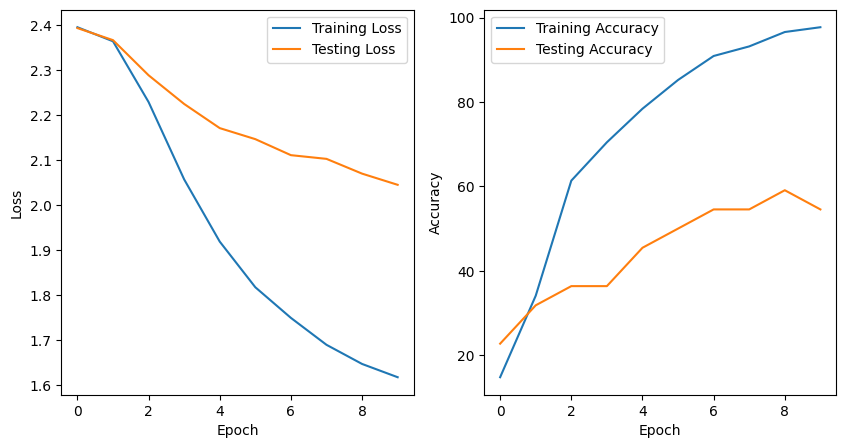

In [75]:
# Plot training and testing losses and accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()